**Setting the working directory**

In [1]:
import os
os.chdir('/Users/shovonsengupta/Desktop/Python/Notebook')

In [2]:
# Check
!pwd

/Users/shovonsengupta/Desktop/Python/Notebook


In [3]:
# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

**Import relevant libraries**

In [4]:
# Installing DARTS for Time Series
# !pip install 'u8darts[all]'

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf

import logging
logging.disable(logging.CRITICAL)

**Read the Data**

In [6]:
'''Reading the CPI Inflation Dataset: To know more about the dataset and application of ML models for Time Series , please refer to: https://www.rbi.org.in/Scripts/PublicationsView.aspx?id=18977'''

'Reading the CPI Inflation Dataset: To know more about the dataset and application of ML models for Time Series , please refer to: https://www.rbi.org.in/Scripts/PublicationsView.aspx?id=18977'

In [7]:
# Read the relevant Data series
import pandas as pd
base_series = pd.read_csv('/Users/shovonsengupta/Desktop/Python/Notebook/DARTS-Time_Series/Machine-Learning-Algorithm-in-7-Days/Datasets/CPI_series_Inflation.csv')

In [8]:
base_series.head()

,Year,CPI_combined,CPI_Headline_Inflation,Date_n
0,02-Jan,48.725055,5.585586,01/01/02
1,02-Feb,48.641907,5.595668,02/01/02
2,02-Mar,48.974501,5.745063,03/01/02
3,02-Apr,49.223947,5.525847,04/01/02
4,02-May,49.556541,5.486726,05/01/02


In [9]:
# Convert object date_n to datetime[64]
import pandas as pd
base_series['date']= pd.to_datetime(base_series['Date_n'])

In [10]:
base_series.head()

,Year,CPI_combined,CPI_Headline_Inflation,Date_n,date
0,02-Jan,48.725055,5.585586,01/01/02,2002-01-01
1,02-Feb,48.641907,5.595668,02/01/02,2002-02-01
2,02-Mar,48.974501,5.745063,03/01/02,2002-03-01
3,02-Apr,49.223947,5.525847,04/01/02,2002-04-01
4,02-May,49.556541,5.486726,05/01/02,2002-05-01


In [11]:
# Creating the series with only relevent information
base_series_new=base_series[['date','CPI_Headline_Inflation']]
base_series_new.reset_index(drop=True)
base_series_new.head()

,date,CPI_Headline_Inflation
0,2002-01-01,5.585586
1,2002-02-01,5.595668
2,2002-03-01,5.745063
3,2002-04-01,5.525847
4,2002-05-01,5.486726


In [12]:
# Let's check the data spread
print(base_series_new['date'].max())
print(base_series_new['date'].min())

2018-12-01 00:00:00
2002-01-01 00:00:00


In [13]:
# Check for Missing Values
base_series_new.isnull().sum()

date                      0
CPI_Headline_Inflation    0
dtype: int64

In [14]:
# Basic Visualisation
series = TimeSeries.from_dataframe(base_series_new, 'date', ['CPI_Headline_Inflation'])

# Create training and validation sets:
train, val = series.split_after(pd.Timestamp('2018-01-01'))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

In [15]:
print("train data",train)
print("val data",val)

train data             CPI_Headline_Inflation
date                              
2002-01-01                5.585586
2002-02-01                5.595668
2002-03-01                5.745063
2002-04-01                5.525847
2002-05-01                5.486726
...                            ...
2017-09-01                3.284950
2017-10-01                3.576865
2017-11-01                4.878049
2017-12-01                5.214724
2018-01-01                5.065234

[193 rows x 1 columns]
Freq: MS
val data             CPI_Headline_Inflation
date                              
2018-02-01                4.441041
2018-03-01                4.278075
2018-04-01                4.576659
2018-05-01                4.870624
2018-06-01                4.924242
2018-07-01                4.172876
2018-08-01                3.692762
2018-09-01                3.772189
2018-10-01                3.379868
2018-11-01                2.325581
2018-12-01                2.186589
Freq: MS


In [16]:
print("train data - scaled",train_transformed)
print("val data - scaled",val_transformed)

train data - scaled                    0
date                
2002-01-01  0.345861
2002-02-01  0.346706
2002-03-01  0.359232
2002-04-01  0.340853
2002-05-01  0.337573
...              ...
2017-09-01  0.152972
2017-10-01  0.177447
2017-11-01  0.286540
2017-12-01  0.314767
2018-01-01  0.302234

[193 rows x 1 columns]
Freq: MS
val data - scaled                    0
date                
2018-02-01  0.249901
2018-03-01  0.236237
2018-04-01  0.261271
2018-05-01  0.285918
2018-06-01  0.290413
2018-07-01  0.227417
2018-08-01  0.187164
2018-09-01  0.193823
2018-10-01  0.160930
2018-11-01  0.072537
2018-12-01  0.060884
Freq: MS


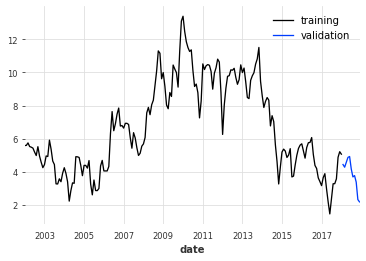

In [17]:
train.plot(label='training')
val.plot(label='validation')
plt.legend();

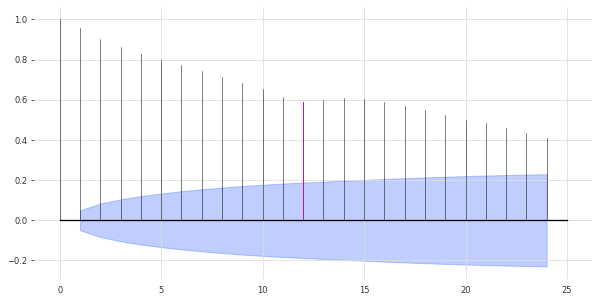

In [18]:
# Check for Seasonality
# Inspect Seasonality
plot_acf(train, m = 12, alpha = .05)

In [19]:
# Statistical Checks for seasonality
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=.05)
    if is_seasonal:
        print('There is seasonality of order {}.'.format(period))

There is seasonality of order 14.


**Set the Hyper-parameters**

In [20]:
'''Appliation of RNN Models (LSTM and GRU) for CPI Inflation Data'''

'Appliation of RNN Models (LSTM and GRU) for CPI Inflation Data'

In [21]:
'''These HPs should be changed based on some HP tuning exercise and here we are using the following values based on some historic experiments'''

'These HPs should be changed based on some HP tuning exercise and here we are using the following values based on some historic experiments'

In [22]:
# Some hyper-parameters:
# Number of previous time stamps taken into account.
SEQ_LENGTH = 3
# Number of features in last hidden state
HIDDEN_SIZE = 200
# number of output time-steps to predict
OUTPUT_LEN = 1
# Number of stacked rnn layers.
NUM_LAYERS = 1

In [23]:
!pwd

/Users/shovonsengupta/Desktop/Python/Notebook


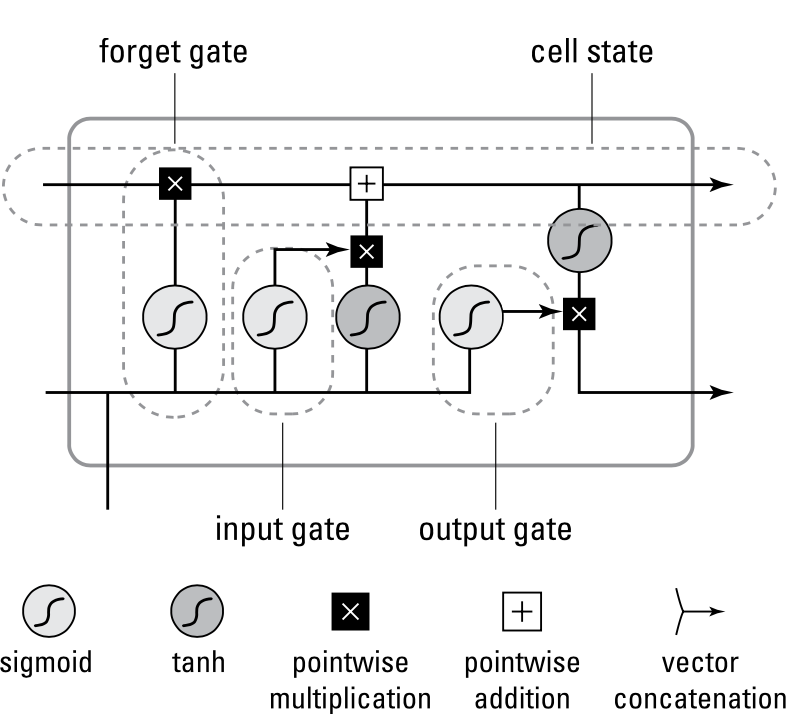

In [24]:
from IPython.display import Image
Image(filename='/Users/shovonsengupta/Desktop/All/PayPal - workshop/LSTM.png',width=400, height=100)

In [25]:
# Let's train an LSTM neural net. For using vanilla RNN or GRU instead, replace 'LSTM' by 'RNN' or 'GRU', respectively.
my_model_RNN_LSTM = RNNModel(
    model='LSTM',
    output_length=OUTPUT_LEN,
    hidden_size=HIDDEN_SIZE,
    n_rnn_layers=NUM_LAYERS,
    input_length=SEQ_LENGTH,
    dropout=0.4,
    batch_size=16,
    n_epochs=500,
    optimizer_kwargs={'lr': 1e-3}, 
    model_name='CPI_RNN_LSTM',
    log_tensorboard=True,
    random_state=42
)

In [26]:
train_transformed

                   0
date                
2002-01-01  0.345861
2002-02-01  0.346706
2002-03-01  0.359232
2002-04-01  0.340853
2002-05-01  0.337573
...              ...
2017-09-01  0.152972
2017-10-01  0.177447
2017-11-01  0.286540
2017-12-01  0.314767
2018-01-01  0.302234

[193 rows x 1 columns]
Freq: MS

In [27]:
val_transformed

                   0
date                
2018-02-01  0.249901
2018-03-01  0.236237
2018-04-01  0.261271
2018-05-01  0.285918
2018-06-01  0.290413
2018-07-01  0.227417
2018-08-01  0.187164
2018-09-01  0.193823
2018-10-01  0.160930
2018-11-01  0.072537
2018-12-01  0.060884
Freq: MS

**Fit the RNN-LSTM model as defined above**

In [28]:
my_model_RNN_LSTM.fit(train_transformed, val_training_series=val_transformed, verbose=True)

Training loss: 0.0195, validation loss: 0.0040


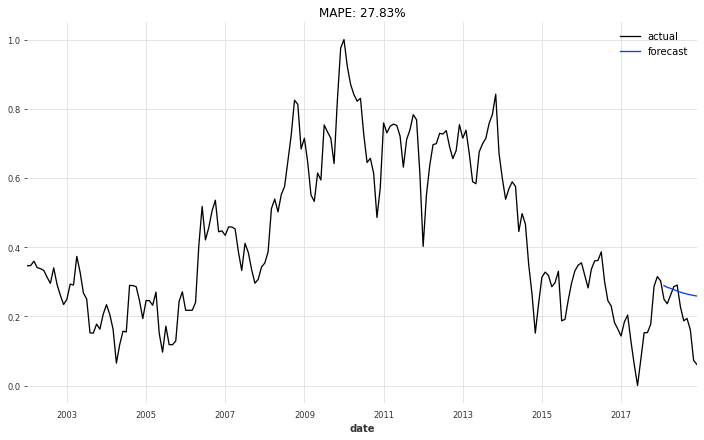

In [29]:
# Look at predictions on the validation set
# Use the "current" model - i.e., the model at the end of the training procedure:
def eval_model(model):
    pred_series = model.predict(n=11)
    plt.figure(figsize=(12,7))
    series_transformed.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_transformed)))
    plt.legend();
    
eval_model(my_model_RNN_LSTM)

In [30]:
val_transformed

                   0
date                
2018-02-01  0.249901
2018-03-01  0.236237
2018-04-01  0.261271
2018-05-01  0.285918
2018-06-01  0.290413
2018-07-01  0.227417
2018-08-01  0.187164
2018-09-01  0.193823
2018-10-01  0.160930
2018-11-01  0.072537
2018-12-01  0.060884
Freq: MS

In [31]:
pred_series = my_model_RNN_LSTM.predict(n=11)
pred_series

                   0
2018-02-01  0.288739
2018-03-01  0.283776
2018-04-01  0.280939
2018-05-01  0.277195
2018-06-01  0.273246
2018-07-01  0.269820
2018-08-01  0.266919
2018-09-01  0.264385
2018-10-01  0.262161
2018-11-01  0.260234
2018-12-01  0.258586
Freq: MS

loading model_best_160.pth.tar


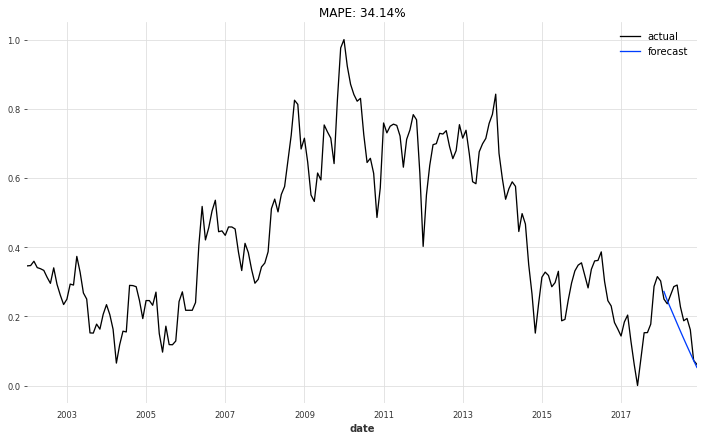

In [32]:
# Use the best model obtained over training, according to validation loss:
best_model = RNNModel.load_from_checkpoint(model_name='CPI_RNN_LSTM', best=True)
eval_model(best_model)

In [33]:
'''Let's backtest our RNN model, to see how it performs at a forecast horizon of 3 months:'''

"Let's backtest our RNN model, to see how it performs at a forecast horizon of 3 months:"

In [34]:
# Backtesting
# Let's backtest our RNN model, to see how it performs at a forecast horizon of 6 months:
backtest_series = my_model_RNN_LSTM.historical_forecasts(series_transformed,
                                                start=pd.Timestamp('2018-01-01'),
                                                forecast_horizon=3,
                                                retrain=False,
                                                verbose=True)

MAPE: 22.41%


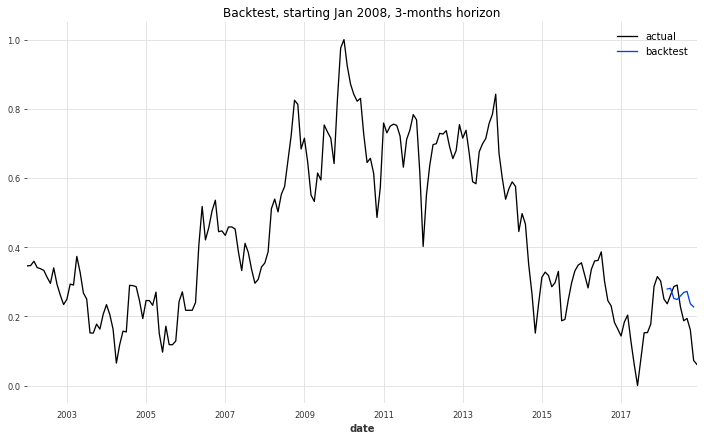

In [35]:
plt.figure(figsize=(12,7))
series_transformed.plot(label='actual')
backtest_series.plot(label='backtest')
plt.legend()
plt.title('Backtest, starting Jan 2008, 3-months horizon');
print('MAPE: {:.2f}%'.format(mape(transformer.inverse_transform(series_transformed), 
                                  transformer.inverse_transform(backtest_series))))

**GRU Model**

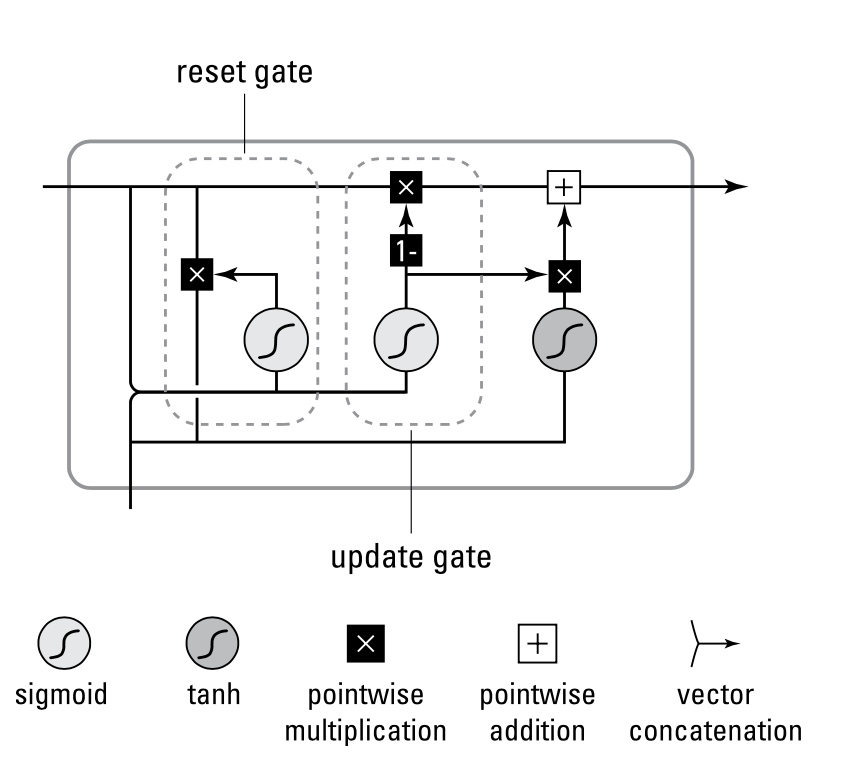

In [36]:
from IPython.display import Image
Image(filename='/Users/shovonsengupta/Desktop/All/PayPal - workshop/GRU.png',width=400, height=100)

In [37]:
my_model_gru = RNNModel(
    model='GRU',
    output_length=OUTPUT_LEN*5,
    input_length=SEQ_LENGTH,
    hidden_size=HIDDEN_SIZE,
    n_rnn_layers=NUM_LAYERS,
    batch_size=64,
    n_epochs=1000,
    dropout=0.3,
    model_name='CPI_GRU_out12',
    log_tensorboard=True,
    random_state=42
)

In [38]:
my_model_gru.fit(train_transformed, val_training_series=val_transformed, verbose=True)

Training loss: 0.0198, validation loss: 0.0092


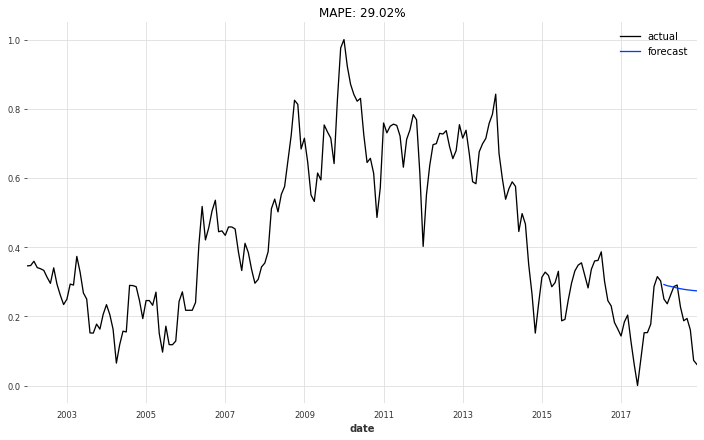

In [39]:
# Look at predictions on the validation set
# Use the "current" model - i.e., the model at the end of the training procedure:
def eval_model(model):
    pred_series = model.predict(n=11)
    plt.figure(figsize=(12,7))
    series_transformed.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_transformed)))
    plt.legend();
    
eval_model(my_model_gru)

loading model_best_880.pth.tar


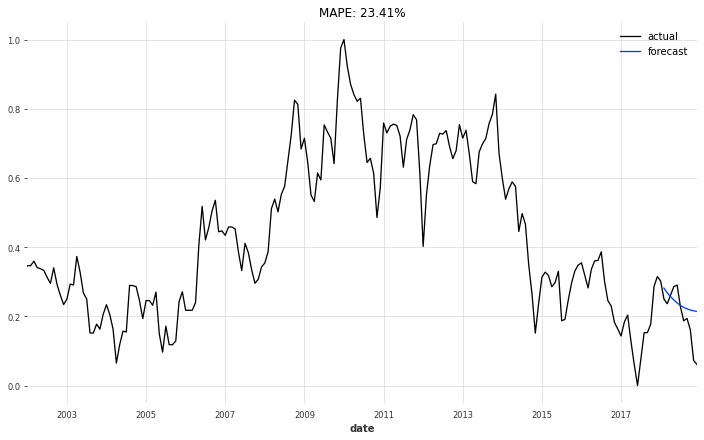

In [40]:
# Use the best model obtained over training, according to validation loss:
best_model = RNNModel.load_from_checkpoint(model_name='CPI_GRU_out12', best=True)
eval_model(best_model)

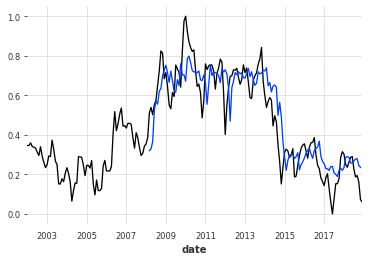

In [41]:
# Backtest with 3 month forecasting horizon
backtest_series = my_model_gru.historical_forecasts(series_transformed,
                                                    start=pd.Timestamp('2008-01-01'),
                                                    forecast_horizon=3,
                                                    retrain=False,
                                                    verbose=True)
series_transformed.plot()
backtest_series.plot()

MAPE: 18.77%


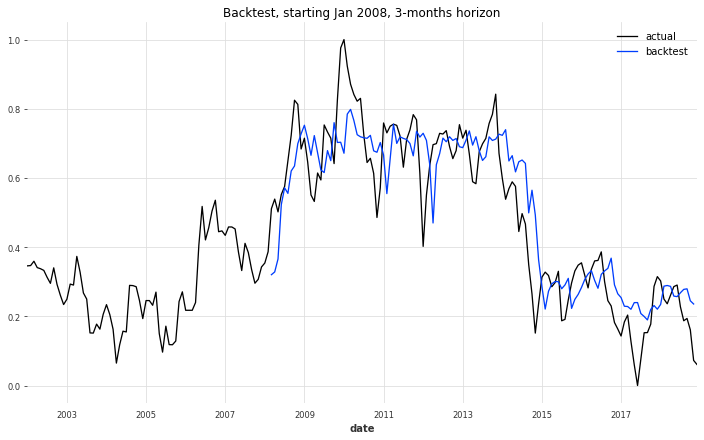

In [42]:
plt.figure(figsize=(12,7))
series_transformed.plot(label='actual')
backtest_series.plot(label='backtest')
plt.legend()
plt.title('Backtest, starting Jan 2008, 3-months horizon');
print('MAPE: {:.2f}%'.format(mape(transformer.inverse_transform(series_transformed), 
                                  transformer.inverse_transform(backtest_series))))

**Best Alternative Model for the CPI - Inflation Series**

In [43]:
# !pip install tsfresh

In [44]:
# Import relevent dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tsfresh
import statsmodels

In [45]:
# Read the relevant Data series
import pandas as pd
base_series = pd.read_csv('/Users/shovonsengupta/Desktop/Python/Notebook/DARTS-Time_Series/Machine-Learning-Algorithm-in-7-Days/Datasets/CPI_series_Inflation.csv')

In [46]:
base_series.head()

,Year,CPI_combined,CPI_Headline_Inflation,Date_n
0,02-Jan,48.725055,5.585586,01/01/02
1,02-Feb,48.641907,5.595668,02/01/02
2,02-Mar,48.974501,5.745063,03/01/02
3,02-Apr,49.223947,5.525847,04/01/02
4,02-May,49.556541,5.486726,05/01/02


In [47]:
# Convert object date_n to datetime[64]
import pandas as pd
base_series['date']= pd.to_datetime(base_series['Date_n'])

In [48]:
base_series.dtypes

Year                              object
CPI_combined                     float64
CPI_Headline_Inflation           float64
Date_n                            object
date                      datetime64[ns]
dtype: object

In [49]:
# Creating the series with only relevent information
base_series_new=base_series[['date','CPI_Headline_Inflation']]
base_series_new.reset_index(drop=True)
base_series_new.head()

,date,CPI_Headline_Inflation
0,2002-01-01,5.585586
1,2002-02-01,5.595668
2,2002-03-01,5.745063
3,2002-04-01,5.525847
4,2002-05-01,5.486726


In [50]:
base_series = base_series_new.set_index('date')
base_series.index

DatetimeIndex(['2002-01-01', '2002-02-01', '2002-03-01', '2002-04-01',
               '2002-05-01', '2002-06-01', '2002-07-01', '2002-08-01',
               '2002-09-01', '2002-10-01',
               ...
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', name='date', length=204, freq=None)

In [51]:
# Create the Series
y = base_series['CPI_Headline_Inflation'].resample('MS').mean()
y['2018':]

date
2018-01-01    5.065234
2018-02-01    4.441041
2018-03-01    4.278075
2018-04-01    4.576659
2018-05-01    4.870624
2018-06-01    4.924242
2018-07-01    4.172876
2018-08-01    3.692762
2018-09-01    3.772189
2018-10-01    3.379868
2018-11-01    2.325581
2018-12-01    2.186589
Freq: MS, Name: CPI_Headline_Inflation, dtype: float64

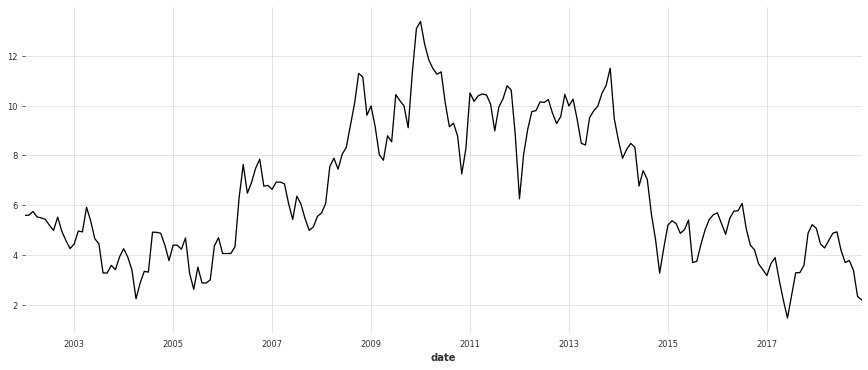

In [52]:
# Visualizing Inflation Time Series Data
y.plot(figsize=(15, 6))
plt.show()

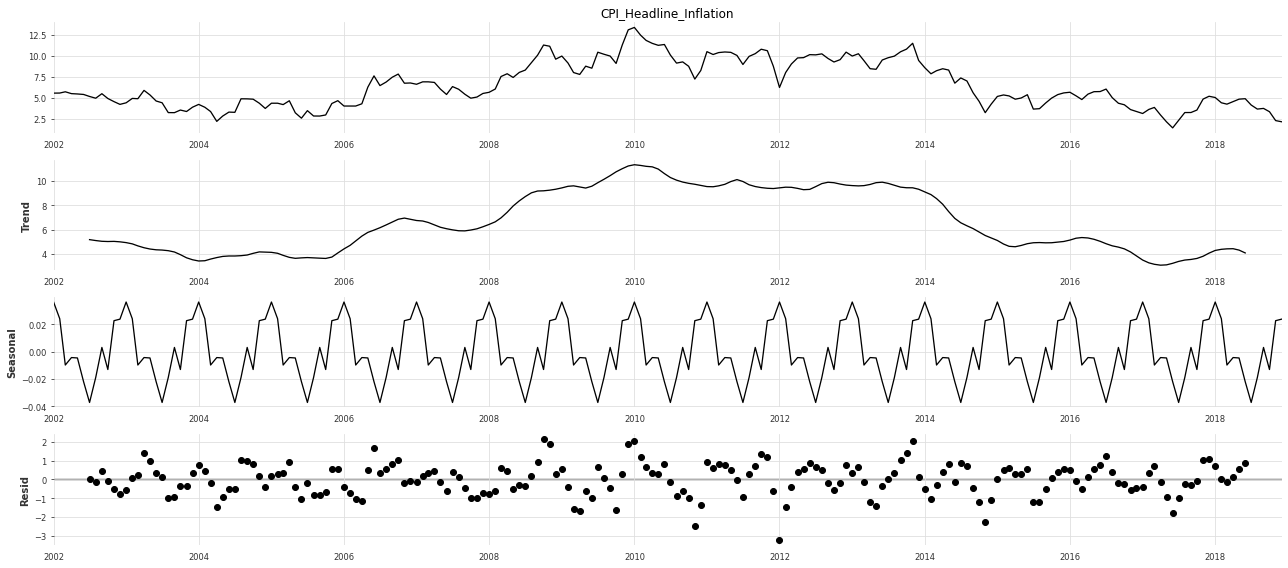

In [53]:
# Check for various component of the Time Series
import statsmodels as sm
from statsmodels.graphics import utils
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition_add = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition_add.plot()
plt.show()

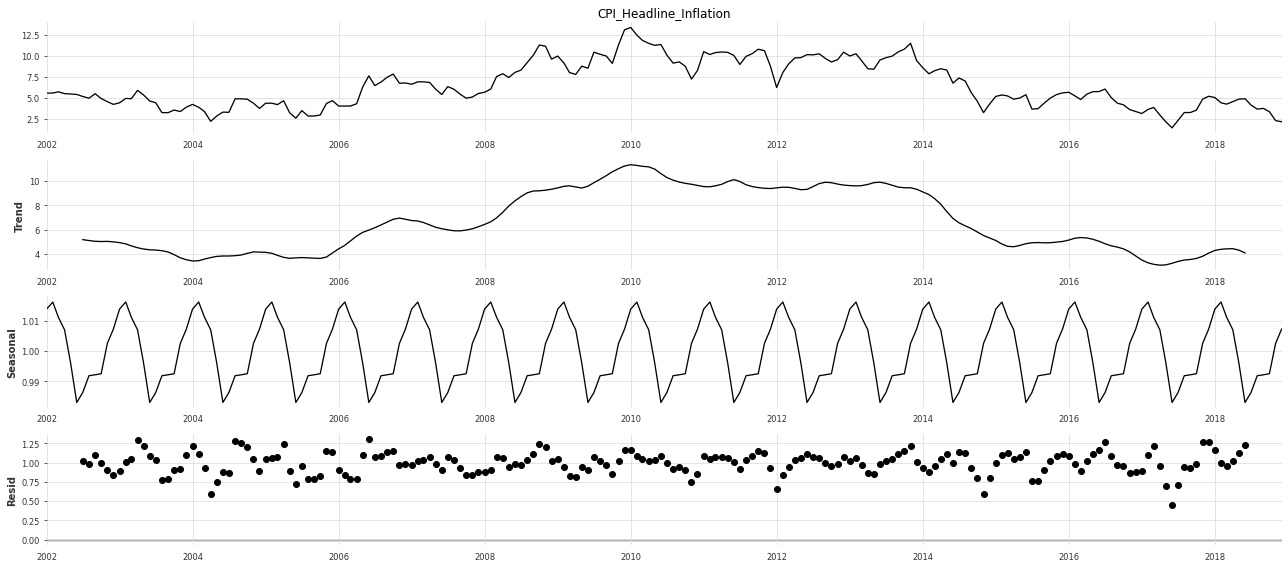

In [54]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition_mul = sm.tsa.seasonal_decompose(y, model='multiplicative')
fig = decomposition_mul.plot()
plt.show()

In [55]:
# A Quick check of stationarity
#Run ADF test on the original time series
from statsmodels.tsa import stattools
from statsmodels.tsa import seasonal
adf_result = stattools.adfuller(base_series['CPI_Headline_Inflation'], autolag='AIC')
print('p-val of the ADF test on irregular variations in CPI series data:', adf_result[1])

p-val of the ADF test on irregular variations in CPI series data: 0.8100920142967409


In [56]:
#Run ADF test on the irregular variations - Multiplicative Model
adf_result = stattools.adfuller(decomposition_add.resid[np.where(np.isfinite(decomposition_add.resid))[0]],
                                autolag='AIC')
print('p-val of the ADF test on irregular variations in CPI Data:', adf_result[1])

p-val of the ADF test on irregular variations in CPI Data: 3.333916863245594e-08


In [57]:
#Run ADF test on the irregular variations - Multiplicative Model
adf_result = stattools.adfuller(decomposition_mul.resid[np.where(np.isfinite(decomposition_mul.resid))[0]],
                                autolag='AIC')
print('p-val of the ADF test on irregular variations in CPI Data:', adf_result[1])

p-val of the ADF test on irregular variations in CPI Data: 7.405904805470883e-08


**Differencing - Basic check for Stationarity**

In [58]:
# First Order Differencing
first_order_diff = base_series['CPI_Headline_Inflation'].diff(1)

Text(0.5, 1.0, 'First-order differences of CPI data - 2000 to 2018')

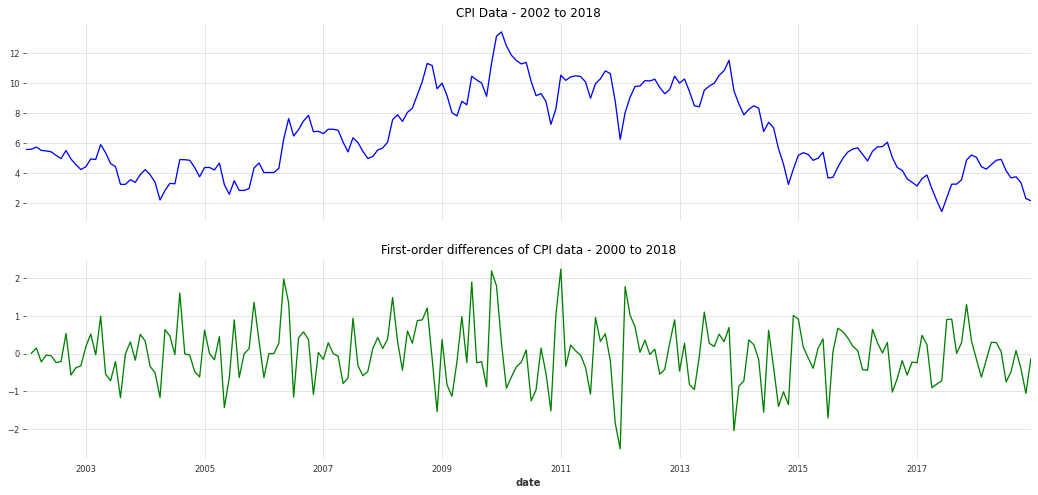

In [59]:
#Let us plot the original time series and first-differences
fig, ax = plt.subplots(2, sharex=True)
base_series['CPI_Headline_Inflation'].plot(ax=ax[0], color='b')
ax[0].set_title('CPI Data - 2002 to 2018')
first_order_diff.plot(ax=ax[1], color='g')
ax[1].set_title('First-order differences of CPI data - 2000 to 2018')

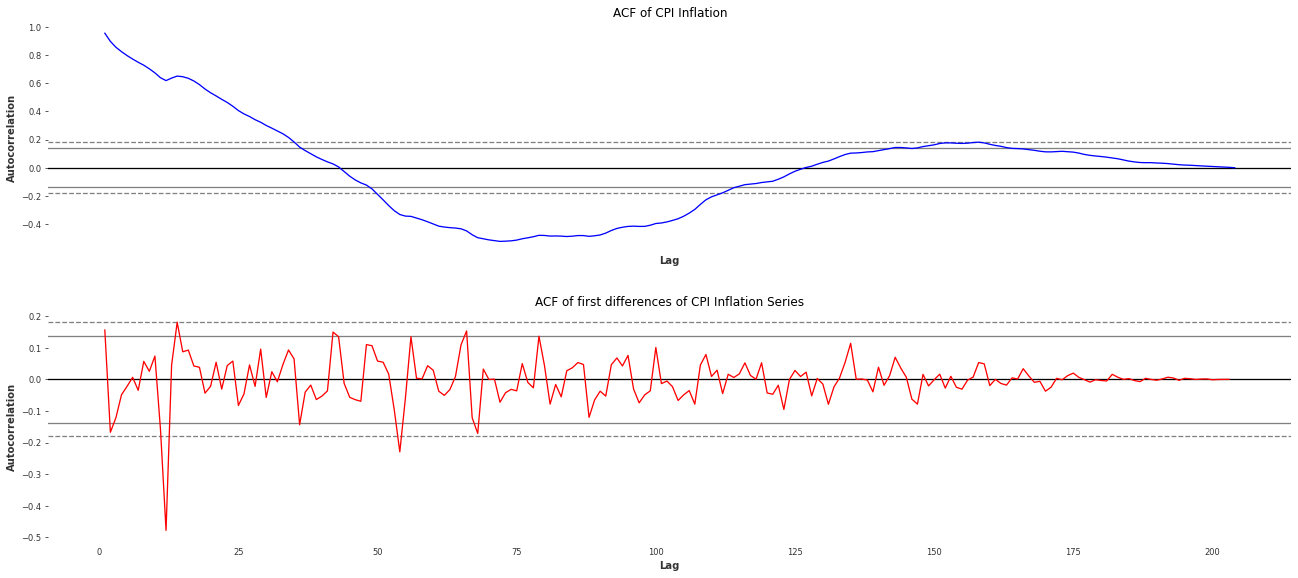

In [60]:
#Let us plot the ACFs of original time series and first-differences
from pandas.plotting import autocorrelation_plot
fig, ax = plt.subplots(2, sharex=True)
autocorrelation_plot(base_series['CPI_Headline_Inflation'], color='b', ax=ax[0])
ax[0].set_title('ACF of CPI Inflation')
autocorrelation_plot(first_order_diff.iloc[1:], color='r', ax=ax[1])
ax[1].set_title('ACF of first differences of CPI Inflation Series')
plt.tight_layout(pad=0.6, w_pad=0.6, h_pad=3.0)

In [61]:
'''Now we could perform the Ljung-Box test on the ACFs of the original time series and the first-differences. For running the test we can limit upto specified Lags'''

'Now we could perform the Ljung-Box test on the ACFs of the original time series and the first-differences. For running the test we can limit upto specified Lags'

**Building the ARIMA Model**

In [62]:
base_series.index = pd.to_datetime(base_series.index)

In [63]:
base_series.columns = ['CPI_Headline_Inflation']

In [64]:
base_series.head()

,CPI_Headline_Inflation
date,
2002-01-01,5.585586
2002-02-01,5.595668
2002-03-01,5.745063
2002-04-01,5.525847
2002-05-01,5.486726


In [65]:
# We will be using pmdarima package
import pmdarima

In [66]:
# Grid-Search and Cross Validation 
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(base_series, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=487.498, BIC=503.760, Time=1.072 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=661.615, BIC=668.120, Time=0.015 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=544.638, BIC=557.647, Time=0.186 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=487.049, BIC=500.058, Time=0.786 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=659.625, BIC=662.878, Time=0.015 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=656.039, BIC=669.048, Time=0.085 seconds
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=449.523, BIC=469.037, Time=1.444 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
F

In [67]:
stepwise_model.aic()

428.66844025832984

In [68]:
# Train-Test Split
train_cpi = base_series.loc['2002-01-01':'2018-06-01']
test_cpi = base_series.loc['2018-07-01':]

In [69]:
train_cpi.tail()

,CPI_Headline_Inflation
date,
2018-02-01,4.441041
2018-03-01,4.278075
2018-04-01,4.576659
2018-05-01,4.870624
2018-06-01,4.924242


In [70]:
test_cpi.head()

,CPI_Headline_Inflation
date,
2018-07-01,4.172876
2018-08-01,3.692762
2018-09-01,3.772189
2018-10-01,3.379868
2018-11-01,2.325581


In [71]:
# Fit the Model with the Train Data
stepwise_model.fit(train_cpi)

ARIMA(order=(1, 1, 1), seasonal_order=(0, 1, 2, 12), suppress_warnings=True)

In [72]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(train_cpi, 
                                trend='c', 
                                order=(3,1,1),
                                seasonal_order=(2, 1, 1, 12))
res = mod.fit(disp=-1)
print(res.summary())

/Users/shovonsengupta/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/shovonsengupta/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                     SARIMAX Results                                      
Dep. Variable:             CPI_Headline_Inflation   No. Observations:                  198
Model:             SARIMAX(3, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -209.053
Date:                            Mon, 16 Nov 2020   AIC                            436.107
Time:                                    10:43:20   BIC                            465.090
Sample:                                01-01-2002   HQIC                           447.853
                                     - 06-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0301      0.023     -1.307      0.191      -0.075       0.015
ar.L1         -0.6314      0.174   

In [73]:
# Calculating MAPE for the last 6 Month's data
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [74]:
forecasts = pd.DataFrame(res.forecast(steps=6))
forecasts.columns = ['Forecast']
forecasts

,Forecast
2018-07-01,4.252225
2018-08-01,3.799255
2018-09-01,3.827663
2018-10-01,3.512394
2018-11-01,2.804732
2018-12-01,2.496254


In [75]:
pred = pd.concat([test_cpi,forecasts],axis=1)
pred.head()

,CPI_Headline_Inflation,Forecast
2018-07-01,4.172876,4.252225
2018-08-01,3.692762,3.799255
2018-09-01,3.772189,3.827663
2018-10-01,3.379868,3.512394
2018-11-01,2.325581,2.804732


In [76]:
mean_absolute_percentage_error(pred['CPI_Headline_Inflation'],pred['Forecast'])

7.490414381891765

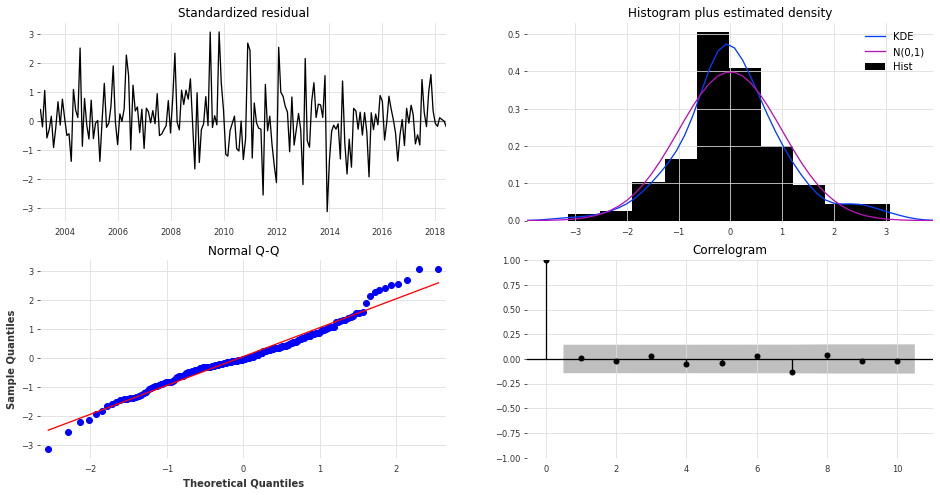

In [77]:
# Check the Model Diagnostics
res.plot_diagnostics(figsize=(16, 8))
plt.show()

In [78]:
'''Congratulations!'''

'Congratulations!'

**Alternative Implementation of RNN-LSTM for Time Series Data**

***Keras Based Implementation***